In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import ephem
import math
from datetime import timedelta
import matplotlib.dates as mdates

from datetime import datetime
from dateutil.relativedelta import relativedelta


### Read in the shadow dat
import glob



In [12]:
def calculate_solar_cos_zenith(datetime_obj):
    observer = ephem.Observer()
    latitude  = 38.980762    # ERW
    longitude = -107.005017  # ERW
    observer.lat = str(latitude)
    observer.lon = str(longitude)
    observer.date = datetime_obj

    sun = ephem.Sun(observer)
    solar_altitude = sun.alt

    # Calculate zenith angle (90 degrees - solar altitude)
    zenith_angle = math.pi / 2.0 - solar_altitude
    # Calculate cosine of zenith angle
    cos_zenith = math.cos(zenith_angle)

    return cos_zenith

def calculate_solar_az(datetime_obj):
    observer = ephem.Observer()
    lat  = 38.980762    # ERW
    lon = -107.005017  # ERW
    observer.lat = str(lat)
    observer.lon = str(lon)
    observer.date = datetime_obj
    sun = ephem.Sun(observer)

    return sun.az

### make an empty dataframe with solar geometry information

In [13]:
df = pd.DataFrame(dict(time=pd.date_range(start='2021-09-01', end='2023-06-15', freq='1H')))

In [14]:
df['cza'] = df['time'].apply(calculate_solar_cos_zenith)
df['az'] = df['time'].apply(calculate_solar_az)
df=df.set_index('time')

### read in model files 

In [15]:
lw_up_clear = pd.read_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/lw_up_clear_xgb.csv", index_col=0, parse_dates=True)
rrtmg_swd   = pd.read_csv("/global/homes/r/rudisill/gshare/sail_data_will/rrtmg/rrtmgClearSkySW_and_M1Obs_SailPeriod_all_o3_ceresAer_0611.csv", index_col=0, parse_dates=True)
rrtmg_lwd    = pd.read_csv("/global/cfs/cdirs/m4099/gsharing/sail_data_will/rrtmg/rrtmgClearSkyLW_SailPeriod.csv", index_col=0, parse_dates=True)

### process the shadow data

In [16]:
def convert_azimuth(azimuth):
    # Convert azimuth from the provided convention to standard convention
    #azimuth_standard =  (180 - azimuth ) % 360#
    return np.radians(azimuth)

def angular_distance(angle1, angle2):
    """
    Calculate the angular distance between two angles in radians.
    """
    # Ensure angles are within the range [-pi, pi]
    angle1 = math.atan2(math.sin(angle1), math.cos(angle1))
    angle2 = math.atan2(math.sin(angle2), math.cos(angle2))
    
    # Calculate the absolute difference between the angles
    diff = abs(angle1 - angle2)
    
    # Return the minimum angular distance, accounting for wrapping around
    return min(diff, 2*math.pi - diff)

In [17]:
hangle = xr.open_dataset("/global/u1/r/rudisill/gshare2/will_data/shadowing/hangle_with_dims.nc") ## this is the horizon angle dat 

In [18]:
x = 327889.75427288306  # these are the UTM coordinates of M1
y = 4313811.21370096 
hangle_m1 = np.cos(((90 - hangle.sel(x=x, y=y, method="nearest").hangle)/180 * np.pi))

In [19]:
hangle_m1_df = pd.DataFrame(index=convert_azimuth(hangle_m1.azimuth), data={'hangle_m1':hangle_m1})

In [20]:
def get_closest_hang(az):
    ang_diffs = hangle_m1_df.index.map(lambda x: angular_distance(x, az)) 
    idx = ang_diffs.argmin()
    return hangle_m1_df.iloc[idx].hangle_m1 # this is in radians. 0 is horizon, 1 is zenith. 

In [21]:
df['hangle'] = df.az.map(get_closest_hang)

In [22]:
df['shadow'] = df['cza'] < df['hangle']

In [23]:
df['shadow'] = df.shadow.astype(float)

### read in observed files

In [24]:
# get the observations from the sail data
qcrad  = xr.open_mfdataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/qcrad/*.cdf")

In [25]:
swdx      = qcrad.BestEstimate_down_short_hemisp.where(qcrad.qc_BestEstimate_down_short_hemisp == 0).resample(time="1h").interpolate('linear').to_pandas()
swdx_dsh  = qcrad.down_short_hemisp.where(qcrad.qc_down_short_hemisp == 0).resample(time="1h").interpolate('linear').to_pandas()
swux      = qcrad.up_short_hemisp.where(qcrad.qc_up_short_hemisp == 0).resample(time="1h").interpolate('linear').to_pandas()
zenith    = qcrad.zenith.resample(time="1h").interpolate('linear').to_pandas()
lwdx      = qcrad.down_long_hemisp.where(qcrad.qc_down_long_hemisp == 0).resample(time="1h").interpolate('linear').to_pandas()

In [26]:
albedo = swux/swdx
albedo_df = pd.DataFrame({"albedo":albedo, 
                          "swdx":swdx,
                          "swux":swux,
                          'zenith':zenith,
                          "cza":np.cos(np.deg2rad(zenith))}).clip(lower=0).dropna()

#a0 = albedo_df.where(albedo_df.zenith < 70).swdx.resample("1d").mean() # this is the old way
#b0 = albedo_df.where(albedo_df.zenith < 70).swux.resample("1d").mean() # this 
#albedo_daily0=(b0/a0).clip(upper=1)

In [27]:
def get_albedo_near_peak(sub):
    max_cza = sub.cza.argmax()
    data = sub.iloc[max_cza-1:max_cza+1]
    data = data.where(data.swdx > data.swux).dropna()
    return data.swux.mean()/data.swdx.mean()

In [28]:
albedo_daily = albedo_df.resample("1d").apply(get_albedo_near_peak)
# now let's take the daily albedo and inteprolate it to hourly.
albedo_hourly = albedo_daily.reindex(df.index, method="nearest").interpolate("linear")

In [29]:
### apply the model from wiscombe and warren... and others... which is implemented in the 
### BATS model to correct the broadband albedo as a function of the solar zenith angle 

def sza_corr(cza, b=2.0):
    rhs = (1/b) *  ( (1+b)/(1 + 2*b*cza) - 1 )
    if cza > .5:
        return 0
    else: 
        return rhs


<AxesSubplot: xlabel='time'>

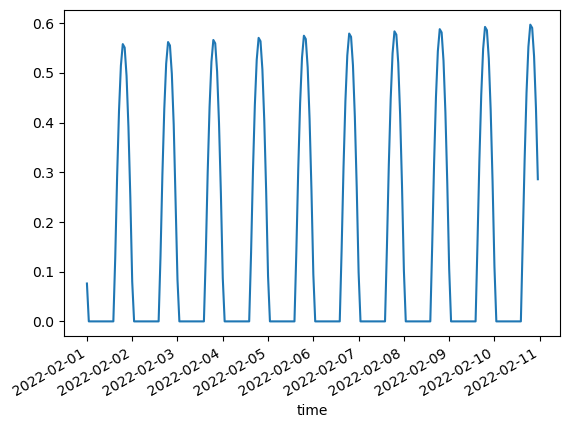

In [30]:
albedo_df['2022-02-01':'2022-02-10'].cza.plot()

In [31]:
fcza = albedo_df.cza.map(sza_corr)

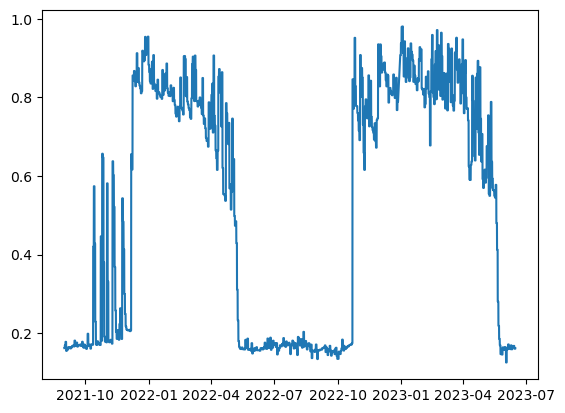

In [32]:
plt.plot(albedo_hourly)

In [33]:
alb_corr = albedo_hourly + .4*fcza*(1-albedo_hourly)

<AxesSubplot: xlabel='time'>

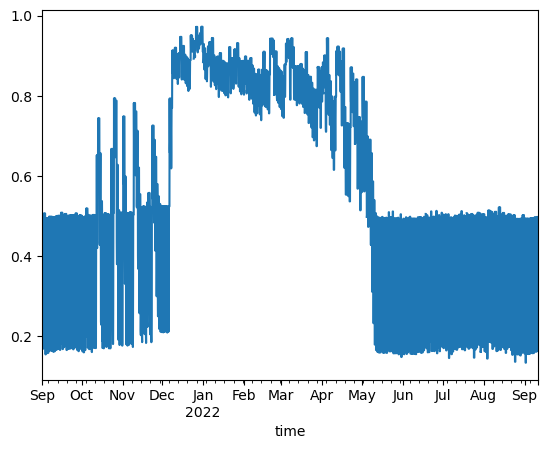

In [34]:
alb_corr['2021-09-01':'2022-09-10'].plot()

In [35]:
albedo_wsa_vis = pd.read_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/clean_data/modis_albedo/albedo_wsa_vis.csv", parse_dates=True, index_col=0, header=0, names=["time", "albedo_wsa_vis"])
albedo_wsa_nir = pd.read_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/clean_data/modis_albedo/albedo_wsa_nir.csv", parse_dates=True, index_col=0, header=0, names=["time", "albedo_wsa_nir"])
albedo_bsa_vis = pd.read_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/clean_data/modis_albedo/albedo_bsa_vis.csv", parse_dates=True, index_col=0, header=0, names=["time", "albedo_bsa_vis"])
albedo_bsa_nir = pd.read_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/clean_data/modis_albedo/albedo_bsa_nir.csv", parse_dates=True, index_col=0, header=0, names=["time", "albedo_bsa_nir"])


Text(0, 0.5, 'albedo')

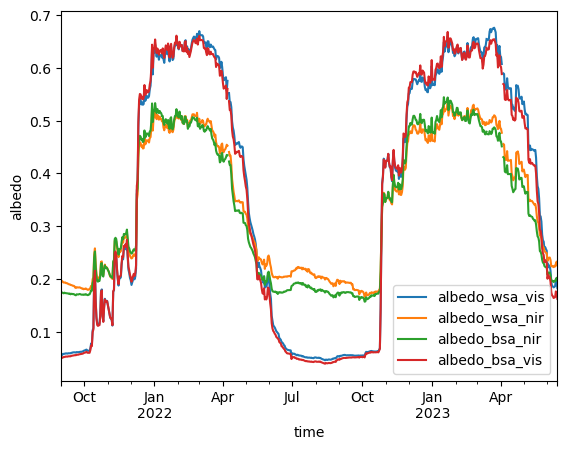

In [36]:
fig, ax = plt.subplots()
(albedo_wsa_vis/1000).plot(ax=ax)
(albedo_wsa_nir/1000).plot(ax=ax)
(albedo_bsa_nir/1000).plot(ax=ax)
(albedo_bsa_vis/1000).plot(ax=ax)
ax.set_ylabel("albedo")

In [37]:
((albedo_df.cza * 1365.0) * (1-alb_corr)).mean()

171.86643171549295

In [38]:
((albedo_df.cza * 1365.0) * (1-albedo_hourly)).mean()

174.6179401885471

In [39]:
df["rrtmg_lwd_clear"]  = rrtmg_lwd.lwdc
df["rrtmg_swd_clear"] = rrtmg_swd.swd.reindex(df.index)
df["rrtmg_swd_toa"]   = rrtmg_swd.swdc_toa.reindex(df.index)
df["qcrad_swd"]       = swdx.reindex(df.index)
df["qcrad_lwd"]       = lwdx.reindex(df.index)
df["qcrad_lwu"]       = lw_up_clear.ulw.resample("1h").interpolate().reindex(df.index)
df["ml_lwu_clear"]    = lw_up_clear.ulw_clear.resample("1h").interpolate().reindex(df.index)  
df["albedo"]          = albedo_hourly


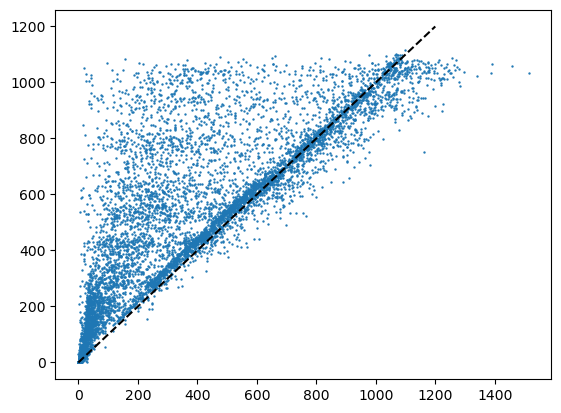

In [40]:
plt.scatter(df.qcrad_swd, df.rrtmg_swd_clear, s=.5)
plt.plot([0,1200],[0,1200], color='black', linestyle='--')

In [41]:
df.rrtmg_swd_clear[0:25] = df.rrtmg_swd_clear[25:50] # there was no data here b/c the sondes(?) were not flown 
df.rrtmg_swd_toa[0:25]   = df.rrtmg_swd_toa[25:50]   # 
df.rrtmg_lwd_clear[0:25] = df.rrtmg_lwd_clear[25:50]  #

In [42]:
df.to_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/master_df_sail_cre.csv")

In [43]:
# now let's save the master dataframe! We are done. 
#mv /global/homes/r/rudisill/gshare2/will_data/crf_files/master_df_sail_cre.csv /global/homes/r/rudisill/gshare2/will_data/crf_files/master_df_sail_cre_OLDVERSION.csv